INDEX/SUMMARY 

The goal of this code is to parse trials and relevant information from a session of data collected on the climbing wall apparatus (CWA) 

Three files are needed: 1) Fiber photometry signal from blackrock (preprocessed to subtract control signal) 2) Touch sensor data collected from CWA (preprocessed from .bin to .mat file) and 3) tracking .csv from deeplabcut- sideview 

Information needed: frames per second of session, sequence performed during session 


What this code will do: Parse trials from a session and classify into backward or forward. Each trial will contain the following information per frame of trial: 

1. Sensor data: 
        -sensor based position 
        -sensor based velocity
        -sensor based acceleration
        -raw touch sensor data (each array is a sensor, (1) == touch, (0)== no touch) 
    
2. Fiber photometry data: 
        -raw signal 
        -1 minute rolling z score signal
    
3. Tracking data: For right forelimb, left forelimb, right hindlimb, left hindlimb: 
        -x, y position 
        -instantaneous velocity based on euclidean distance
        -if error is occuring (1) or not (0)
        -which gap the limb is on/over
        -also, x speed of center of mass 
        
 You can also crop a session video into trials at the end if you want but that takes forever


In [4]:
#DEPENDENCIES

import os, sys 
import subprocess
import h5py
import hdf5storage
import numpy as np 
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import preprocessing
from scipy import signal
import scipy.io as sio
from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy import stats 
import statsmodels.stats.weightstats as sms
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import warnings


In [5]:
########################################### CHANGE VARS HERE ########################################################

directory = '/Volumes/Tori/current_analysis/FP_VTA/'

BRname = directory + 'dff/NC7_07.mat' #blackrock fiber photometry file   
sensor_dir = directory + 'sensor/cwa_NC7_session07_seq1_gr00.mat' #sensor data 
tracking = directory + 'IR_tracking/NC7_session07_seq1_gr00.csv' #sideview tracking from DLC 

fps = 60 
subject = 'NC7' #subject
session = '07' #session (e.g. "02" if 2nd session or "03_laser")
sequence = 1 #1 or 2
save_dir = '/Users/riccellit/Desktop/folder' #directory to save data in 

####################################################################################################################

All the code/processing happens below with 2 checkpoints. 

In [6]:
#FUNCTIONS | READ FILES | PARSE MOVEMENT BOUTS

warnings.filterwarnings('ignore')

############################################# Functions ###########################################

def rolling_z(x, window): # rolling z score 
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

def where_is_it(x, y, gaplist, gapkey): #is point in gap 
    whereisit = [] 
    for i,xpoint in enumerate(np.nan_to_num(x).astype(list)): 
        wassmththere = []
        y2 = np.nan_to_num(y).astype(list)
        for ii, polygon in enumerate(gaplist): 
            if polygon.contains(Point(xpoint,y2[i])) == True: 
                whereisit.append(gapkey[ii])
                wassmththere.append(1)
            else: 
                pass
        if len(wassmththere) <1: 
            whereisit.append(0)
        else:
            pass
    return(whereisit)

def make_it_bool(length, indices): #make a list of zeroes and insert 1 at defined indices
    boolean = [] 
    listz = [0]*length
    for x in indices: 
        listz.pop(int(x)) 
        listz.insert(int(x), 1)
    return(listz)

def one_runs(a): #one runs loc
    iszero = np.concatenate(([0], np.equal(a, 1).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def euc(A,B): #where A is (x1, y1) and B is (x2, y2), euclidean distance for 2D 
    val = np.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2)
    return(val)

print("Step 1 Completed: Function read successful.")
print("")
print("Step 2: Reading files. This may take a while...  ")

############################################  Read the files ###########################################
print("      reading fiber photometry signal...")
#FIBER PHOTOMETRY SIGNAL 
test = sio.loadmat(BRname)
dFF = test['dff'][0]
#dFF = test['signal'][0][0][2][0]
sdFF = signal.resample_poly(dFF, fps/10, 1000)#downsample dFF so it matches fps
sdf = pd.DataFrame({'dff':sdFF})
z_score = rolling_z(sdf, fps*60)['dff'].values #thats a 1 minute rolling z score to cancel out motivation effects 
signalz = sdf['dff'].values #signal without z score 

print("       reading sensor data...")
#SENSOR DATA
f = h5py.File(sensor_dir, 'r')
Sensor = []
struArray = f['sns']
shape = struArray['sns'].shape
shape = shape[0] - 1 
while shape > 0: 
    value = f[struArray['sns'][shape,0]].value 
    Sensor.append(value)
    shape = shape - 1 
frames = np.array([e[0] for e in Sensor])
OnesLoc = []
for array in frames.T: 
    OnesLoc.append(one_runs(array))
ones = []
for sensor in OnesLoc:
    combinedon = [] 
    for touch in sensor: 
        combinedon.append(list(range(touch[0], touch[1]+1)))
    ones.append([x for array in combinedon for x in array])

print("       reading tracking data...")
#TRACKING FROM DLC 
track = pd.read_csv(tracking)
length = len(pd.read_csv(tracking))

print("Step 2 Completed: File read successful.")
print("")
print("Step 3: Parsing trials... ")


########################################### Parse movement bouts ###########################################

#GET POSITION, VELOCITY, & ACCELERATION OF MOUSE

#parse out reward ports 
frames = frames.T[5:94]
frames = frames.T

#get average position based on sensors activated 
position = []
for array in frames: 
    sensorindices = [i for i, x in enumerate(array) if x == 1]
    position.append(np.nanmean(sensorindices))
    
position = list(reversed(position)) #the position is reversed from the way I collected sensor info

#get velocity and acceleration, pad arrays with zeros 
vel = abs(np.diff(position))
vel = list(vel)
vel = [0] + vel
vel = np.asarray(vel)

accel = np.diff(vel) 
accel = np.pad(accel, (1), 'constant', constant_values=(0))

#movement defined when any sensor becomes first active, until sensor becomes not active 
mask = ma.masked_invalid(position)
mask2 = [int(x) for x in ma.getmask(mask)]

diff = np.diff((np.asarray(mask2)).flatten())
indices = [i for i, x in enumerate(diff) if x != 0]

#Add in the first and last indices as they will not be caught by the mask (eg, 0, max length)
indices.append(len(frames)) 
indices = [0] + indices

#FIND DIRECTION OF MOVEMENT BOUT 

#where 1 is forward, 0 is backward 
#basically simple subtraction of position at beginning and end 
if np.isnan(position[(indices[0]+1)] - position[indices[1]-1]) == True: #sometimes indices offset 
    del indices[0]
    
#In this part of the code, 
#I go through every one off situation I've found via "if" statements which is not great but such is life

direction = [] 
if len(indices)>2: #if there is more than one trial 
    for i,x in enumerate(indices):
        if i < len(indices)-2: #because comparison won't work for last index 
            if (i+2)%2 == 0:  #if the number is even 
                if position[(indices[i]+1)] - (position[indices[i+1]]) > 40: 
                    direction.append(1) #forward
                elif position[(indices[i]+1)] - (position[indices[i+1]]) < -40: 
                    direction.append(0) #backward 
                else: 
                    direction.append(np.nan) #not long enough bout of movement
            else: 
                direction.append(direction[-1]) #append the last value for 2nd number  
        else: 
            direction.append(direction[-1]) #append the last value 
else: #if there is only one trial in this session 
    if position[(indices[i]+1)] - position[indices[i+1]-1] > 40: 
        direction.append(1) #forward
    elif position[(indices[i]+1)] - position[indices[i+1]-1] < -40: 
        direction.append(0) #backward 
    else: 
        direction.append(np.nan)
    
        
#making dataframe for visualization purposes and also functions
d = {'indices':indices, 'direction':direction}
df = pd.DataFrame(data=d)

#making boolean mask of indices for forward and backward movement 
df['notna'] = pd.notna(df['direction'])
df['forward'] = df['direction'] ==1
df.forward = df.forward.astype(int)
df['backward'] = df['direction'] == 0
df.backward = df.backward.astype(int)

#get ranges, do a little bit of clean up, and convert to ms 
fsample = [] #for graph check
bsample =[] #for graph check 


for index, boolean in enumerate(df['forward'].values, start=0): 
    if index < len(df)-1:
        if (index + 2) %2 ==0: 
            if boolean == 1: 
                fsample.append([df['indices'][index],df['indices'][index+1]])
            else: 
                pass 
        else: 
            pass
    else: 
        pass
for index, boolean in enumerate(df['backward'].values, start=0): 
    if index < len(df)-1:
        if (index + 2) %2 == 0: 
            if boolean == 1: 
                bsample.append([df['indices'][index],df['indices'][index+1]])
            else: 
                pass 
        else: 
            pass 
    else: 
        pass 
    
#cleaning up the tails of array
backwardRanges = []
for array in bsample: 
    section = position[array[0]: array[1]]
    index = np.where(section == np.nanmin(section))[0][len(np.where(section == np.nanmin(section))[0])-1] 
    index2 = np.where(section==np.nanmax(section))[0][0] 
    backwardRanges.append([(array[0] + index), (array[0] + index2)])
forwardRanges = [] 
for array in fsample:
    section = position[array[0]: array[1]]
    index = np.where(section == np.nanmax(section))[0][len(np.where(section == np.nanmax(section))[0])-1]
    index2 = np.where(section==np.nanmin(section))[0][0] 
    forwardRanges.append([(array[0] + index), (array[0] + index2)])
    
print("Step 3 Completed: Trial parsing successful.")



Step 1 Completed: Function read successful.

Step 2: Reading files. This may take a while...  
      reading fiber photometry signal...
       reading sensor data...
       reading tracking data...
Step 2 Completed: File read successful.

Step 3: Parsing trials... 
Step 3 Completed: Trial parsing successful.


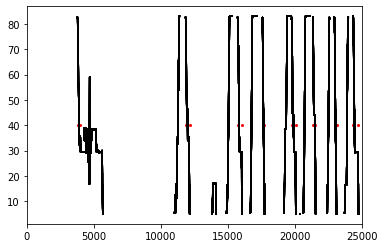

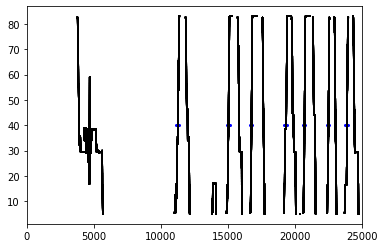

cropped FP file length: 54112
cwa file length: 54002

ALL CHECK COMPLETE: proceed with analysis


In [7]:
#CHECKPOINT: does your trial cropping indices look ok 

for array in forwardRanges: 
    plt.plot(position, color = 'k') 
    plt.scatter(array[0],[40], s= 4, color = 'r')
    plt.scatter(array[1],[40], s =4, color = 'r') 
    plt.xlim(0,25000)
plt.show()
for array in backwardRanges: 
    plt.plot(position, color = 'k') 
    plt.scatter(array[0],[40], s= 4, color = 'b')
    plt.scatter(array[1],[40], s =4, color = 'b') 
    plt.xlim(0,25000)
plt.show()


#CHECKPOINT: did you downsample fp signal correctly 
print("cropped FP file length: " + str(len(sdFF)))
print("cwa file length: " + str(len(Sensor)))
print('')
if round(len(sdFF),-4) == round(len(Sensor), -4): 
    print('ALL CHECK COMPLETE: proceed with analysis') 
else: 
    print('ERROR: blackrock file downsampled incorrectly')
    print(' Check fps and sampling_rate in variables')



Step 4: Opening tracking data...
     cleaning center of mass...
     cleaning right forelimb...
     cleaning left forelimb...
     cleaning right hindlimb...
     cleaning left hindlimb...
Step 4 Completed: Read tracking data.


CHECK POINT: Does tracking data look reasonable? Should be dominated by rung locations.


(Text(0.5, 1.0, 'Left Forelimb'), (72, 540), (0, 100))

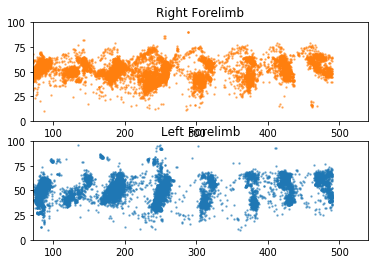

In [104]:
#CLEAN UP TRACKING DATA + CHECKPOINT: does tracking look ok  
######################################## Create tracking data dataframe #####################################
print("Step 4: Opening tracking data...")

#it starts at 2 because the other stuff is just headers 
d = {'RFx': track['DeepCut_resnet50_climbingDec11shuffle1_500000'].values[2:len(track)],
    'RFy': track['DeepCut_resnet50_climbingDec11shuffle1_500000.1'].values[2:len(track)], 
    'RFlikelihood': track['DeepCut_resnet50_climbingDec11shuffle1_500000.2'].values[2:len(track)], 
    'LFx': track['DeepCut_resnet50_climbingDec11shuffle1_500000.3'].values[2:len(track)],
    'LFy': track['DeepCut_resnet50_climbingDec11shuffle1_500000.4'].values[2:len(track)],
    'LFlikelihood': track['DeepCut_resnet50_climbingDec11shuffle1_500000.5'].values[2:len(track)],
    'RHx': track['DeepCut_resnet50_climbingDec11shuffle1_500000.9'].values[2:len(track)],
    'RHy': track['DeepCut_resnet50_climbingDec11shuffle1_500000.10'].values[2:len(track)],
    'RHlikelihood': track['DeepCut_resnet50_climbingDec11shuffle1_500000.11'].values[2:len(track)],
    'LHx': track['DeepCut_resnet50_climbingDec11shuffle1_500000.12'].values[2:len(track)],
    'LHy': track['DeepCut_resnet50_climbingDec11shuffle1_500000.13'].values[2:len(track)],
    'LHlikelihhood': track['DeepCut_resnet50_climbingDec11shuffle1_500000.14'].values[2:len(track)],
    'midx': track['DeepCut_resnet50_climbingDec11shuffle1_500000.6'].values[2:len(track)],
    'midy': track['DeepCut_resnet50_climbingDec11shuffle1_500000.7'].values[2:len(track)],
    'midlikelihood': track['DeepCut_resnet50_climbingDec11shuffle1_500000.8'].values[2:len(track)]}
trackdf = pd.DataFrame(data = d, dtype = np.int8).astype(float)

#tracking gets dicey around the ends of the frames so we are going to get rid of those points 
#going to get rid of any points with drastic difference from one frame to next (eg. y loc goes from 0 to 100)
#invert the y data bc it's upside down 

print('     cleaning center of mass...')
#mid body pos (Center of mass)
body = pd.DataFrame(data= d).astype(float)
body['ydiff'] = abs(np.insert(np.diff(body.midy.values),0, np.nan))
body['xdiff'] = abs(np.insert(np.diff(body.midx.values),0, np.nan))
body['midy'] = body.midy.apply(lambda x: 280-x) #y is inverted
body = body.mask(body.ydiff >30)
body = body.mask(body.xdiff >30)
body = body.mask(body.midy<10)
body = body.mask(body.midy>110)
body = body.mask(body.midx>490)
bodyxsp = np.diff(body.midx.values)
bodyxsp = np.insert(bodyxsp, 0, 0)

print('     cleaning right forelimb...')
#right forelimb filter 
RF = pd.DataFrame(data = d).astype(float)
RF['idx'] = RF.index.values
RF['ydiff'] = abs(np.insert(np.diff(RF.RFy.values),0, np.nan))
RF['xdiff'] = abs(np.insert(np.diff(RF.RFx.values),0, np.nan))
RF['RFy'] = RF.RFy.apply(lambda x: 280-x) #y is inverted
RF = RF.mask(RF.ydiff >30)
RF = RF.mask(RF.xdiff >30)
RF = RF.mask(RF.RFy<10)
RF = RF.mask(RF.RFy>100)
RF = RF.mask(RF.RFx>490)
erry = (RF.where(RF['RFy'] <= 35))['RFy'].values #did error occur 
RFerr = make_it_bool(len(pd.DataFrame({'err':erry})), pd.DataFrame({'err':erry}).dropna().index)

print('     cleaning left forelimb...')
#left forelimb filter
LF = pd.DataFrame(data = d).astype(float)
LF['idx'] = LF.index.values
LF['ydiff'] = abs(np.insert(np.diff(LF.LFy.values),0, np.nan))
LF['xdiff'] = abs(np.insert(np.diff(LF.LFx.values),0, np.nan))
LF['LFy'] = LF.LFy.apply(lambda x: 280-x) #y is inverted   
LF = LF.mask(LF.ydiff >30)
LF = LF.mask(LF.xdiff >30)
LF = LF.mask(LF.LFy<10)
LF = LF.mask(LF.LFy>100)
LF = LF.mask(LF.LFx>490)
erry = (LF.where(LF['LFy'] <= 35))['LFy'].values #did error occur 
LFerr = make_it_bool(len(pd.DataFrame({'err':erry})), pd.DataFrame({'err':erry}).dropna().index)

print('     cleaning right hindlimb...')
#right hindlimb filter 
RH = pd.DataFrame(data = d).astype(float)
RH['idx'] = RH.index.values
RH['ydiff'] = abs(np.insert(np.diff(RH.RHy.values),0, np.nan))
RH['xdiff'] = abs(np.insert(np.diff(RH.RHx.values),0, np.nan))
RH['RHy'] = RH.RHy.apply(lambda x: 280-x) #y is inverted
RH = RH.mask(RH.xdiff >30)
RH = RH.mask(RH.ydiff >30)
RH = RH.mask(RH.RHy<10)
RH = RH.mask(RH.RHy>100)
RH = RH.mask(RH.RHx>490)
erry = (RH.where(RH['RHy'] <= 35))['RHy'].values #did error occur 
RHerr = make_it_bool(len(pd.DataFrame({'err':erry})), pd.DataFrame({'err':erry}).dropna().index)

print('     cleaning left hindlimb...')
#left hindlimb filter
LH = pd.DataFrame(data = d).astype(float)
LH['idx'] = LH.index.values
LH['ydiff'] = abs(np.insert(np.diff(LH.LHy.values),0, np.nan))
LH['xdiff'] = abs(np.insert(np.diff(LH.LHx.values),0, np.nan))
LH['LHy'] = LH.LHy.apply(lambda x: 280-x) #y is inverted
LH = LH.mask(LH.ydiff >30)
LH = LH.mask(LH.xdiff >20)
LH = LH.mask(LH.LHy<10)
LH = LH.mask(LH.LHy>100)
LH = LH.mask(LH.LHx>490)
erry = (LH.where(LH['LHy'] <= 35))['LHy'].values #did error occur 
LHerr = make_it_bool(len(pd.DataFrame({'err':erry})), pd.DataFrame({'err':erry}).dropna().index)

print("Step 4 Completed: Read tracking data.")
print("") 
print("")

print("CHECK POINT: Does tracking data look reasonable? Should be dominated by rung locations.")

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter(RF.RFx.values, RF.RFy.values, s = 2, alpha = 0.5, color = 'tab:orange')
ax1.set_title('Right Forelimb'), ax1.set_xlim(72, 540), ax1.set_ylim(0, 100)
ax2.scatter(LF.LFx.values, LF.LFy.values, s = 2, alpha = 0.5)
ax2.set_title("Left Forelimb"), ax2.set_xlim(72, 540), ax2.set_ylim(0, 100)

Now parse and save your trials. 

In [106]:
# PARSE FORWARD TRIALS AND DATA | PARSE BACKWARD TRIALS AND DATA 

#File includes: #sensor data, sensor position, sensor vel, sensor accel 
                #all limb position, vel, gap loc, if error 
                #fp signal and z scored signal 

# #FORWARD TRIALS
print("Step 5: FORWARD TRIALS... ")
print("")
trial = 0

SensorR = list(reversed(Sensor)) #need to reverse this bc data collected "backwards"

#gap locations change per sequence and slightly per direction of travel 
if sequence ==1: 
        B1 = Polygon([(72, 30), (72,0), (125,0), (125, 30), (135, 80), (100, 80)])
        C1 = Polygon([(125, 30),(125,0), (200,0), (200, 30), (205, 80), (135, 80)])
        A1 = Polygon([(200, 30), (200,0), (255,0), (255, 30), (245, 80), (205, 80)])
        B2 = Polygon([(255, 30), (255,0), (325,0), (325, 30), (290, 80), (245, 80)])
        A2 = Polygon([(325, 30), (325,0), (380,0), (380, 30), (330, 80), (290, 80)])
        C2 = Polygon([(380, 30), (380,0), (468,0), (468, 30), (375, 80), (330, 80)])
        B3 = Polygon([(468, 30), (468,0), (525,0), (525, 30), (435, 80), (375, 80)])
        sensorgap = [[77,78],[64,65],[55,56],[44,45],[35,36],[22,23],[11,12]]
        gaplist = [B1, C1, A1, B2, A2, C2, B3]
        gapkey = ['B1', 'C1', 'A1', 'B2', 'A2', 'C2', 'B3']
elif sequence == 2:        
        B1 = Polygon([(72, 30), (72,0), (125,0),(125, 30), (155, 80), (100, 80)])
        A1 = Polygon([(180, 30), (180,0), (255,0),(255, 30), (250, 80), (195, 80)])
        C1 = Polygon([(125, 30), (125,0), (180,0),(180, 30), (195, 80), (155, 80)])
        B2 = Polygon([(255, 30), (255,0), (325,0),(325, 30), (300, 80), (250, 80)])
        C2 = Polygon([(410, 30), (410,0), (470,0),(470, 30), (385, 80), (345, 80)])
        A2 = Polygon([(325, 30), (325,0), (410,0),(410, 30), (345, 80), (300, 80)])
        B3 = Polygon([(470, 30), (470,0), (540,0),(540, 30), (445, 80), (385, 80)])
        sensorgap = [[76,77, 78],[67,68, 69],[54,55, 56],[43,44, 45],[30,31, 32],[21,22, 23],[10,11,12]]
        gaplist = [B1, A1, C1, B2, C2, A2, B3]
        gapkey = ['B1', 'A1', 'C1', 'B2', 'C2', 'A2', 'B3'] 
else: 
    print('you need to choose either sequence 1 or 2, go back to the beginning and fix it')
        
for array in forwardRanges:
    trial = trial + 1
    print("Analyzing " + str(trial) + " forward...")
    
#SENSOR DATA 
    cropSensor = SensorR[(array[0]):array[1]]#add extra zero to remove array bracket
    cropPos = position[(array[0]): array[1]]
    cropVel = vel[(array[0]): array[1]]
    cropAccel = accel[(array[0]): array[1]]
    
#FP DATA 
    cropsignal = signalz[(array[0]): array[1]]
    cropz = z_score[(array[0]): array[1]]
    
#TRACKING DATA
    cropRFx = RF.RFx.values[array[0]:array[1]]
    cropRFy = RF.RFy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropRFx):
        if ii < len(cropRFx)-1:
            A = [x, cropRFy[ii]]
            B = [cropRFx[ii+1], cropRFy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropRFsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    RFgap = where_is_it(cropRFx, cropRFy, gaplist, gapkey) # where is it 
    cropRFerr = RFerr[array[0]:array[1]]

    cropLFx = LF.LFx.values[array[0]:array[1]]
    cropLFy = LF.LFy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropLFx):
        if ii < len(cropLFx)-1:
            A = [x, cropLFy[ii]]
            B = [cropLFx[ii+1], cropLFy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropLFsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    LFgap = where_is_it(cropLFx, cropLFy, gaplist, gapkey) # where is it 
    cropLFerr = LFerr[array[0]:array[1]]

    cropLHx = LH.LHx.values[array[0]:array[1]]
    cropLHy = LH.LHy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropLHx):
        if ii < len(cropLHx)-1:
            A = [x, cropLHy[ii]]
            B = [cropLHx[ii+1], cropLHy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropLHsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    LHgap = where_is_it(cropLHx, cropLHy, gaplist, gapkey) # where is it 
    cropLHerr = LHerr[array[0]:array[1]]

    cropRHx = RH.RHx.values[array[0]:array[1]]
    cropRHy = RH.RHy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropRHx):
        if ii < len(cropRHx)-1:
            A = [x, cropRHy[ii]]
            B = [cropRHx[ii+1], cropRHy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropRHsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    RHgap = where_is_it(cropRHx, cropRHy, gaplist, gapkey) # where is it 
    cropRHerr = RHerr[array[0]:array[1]]
    cropCOM = bodyxsp[array[0]:array[1]]

    matfiledata = {} 
    if len(str(trial)) == 1: 
        name = '00' + str(trial)
        sio.savemat(save_dir + '/' + str(subject) + '_f_' + str(session) + '_' + name + '.mat', 
                    mdict={'sensor': cropSensor, 'position':cropPos, 'velocity':cropVel, 'acceleration':cropAccel,
                           'dff':cropsignal, 'zscore':cropz, 'COMvel':cropCOM, 
                          'RFx': cropRFx, 'RFy': cropRFy, 'RFsp':cropRFsp, 'RFerr':cropRFerr, 'RFgap':RFgap, 
                          'LFx': cropLFx, 'LFy': cropLFy, 'LFsp':cropLFsp, 'LFerr':cropLFerr, 'LFgap':LFgap, 
                          'RHx': cropRHx, 'RHy': cropRHy, 'RHsp':cropRHsp, 'RHerr':cropRHerr, 'RHgap':RHgap,
                          'LHx': cropLHx, 'LHy': cropLHy, 'LHsp':cropLHsp, 'LHerr':cropLHerr, 'LHgap':LHgap})
    elif len(str(trial)) == 2: 
        name = '0' + str(trial)
        sio.savemat(save_dir + '/' + str(subject) + '_f_' + str(session) + '_' + name + '.mat', 
                    mdict={'sensor': cropSensor, 'position':cropPos, 'velocity':cropVel, 'acceleration':cropAccel,
                           'dff':cropsignal, 'zscore':cropz,'COMvel':cropCOM, 
                          'RFx': cropRFx, 'RFy': cropRFy, 'RFsp':cropRFsp, 'RFerr':cropRFerr, 'RFgap':RFgap, 
                          'LFx': cropLFx, 'LFy': cropLFy, 'LFsp':cropLFsp, 'LFerr':cropLFerr, 'LFgap':LFgap, 
                          'RHx': cropRHx, 'RHy': cropRHy, 'RHsp':cropRHsp, 'RHerr':cropRHerr, 'RHgap':RHgap,
                          'LHx': cropLHx, 'LHy': cropLHy, 'LHsp':cropLHsp, 'LHerr':cropLHerr, 'LHgap':LHgap})
    else: 
        sio.savemat(save_dir + '/' + str(subject) + '_f_' + str(session) + '_' + name + '.mat', 
                    mdict={'sensor': cropSensor, 'position':cropPos, 'velocity':cropVel, 'acceleration':cropAccel,
                           'dff':cropsignal, 'zscore':cropz,'COMvel':cropCOM, 
                          'RFx': cropRFx, 'RFy': cropRFy, 'RFsp':cropRFsp, 'RFerr':cropRFerr, 'RFgap':RFgap, 
                          'LFx': cropLFx, 'LFy': cropLFy, 'LFsp':cropLFsp, 'LFerr':cropLFerr, 'LFgap':LFgap, 
                          'RHx': cropRHx, 'RHy': cropRHy, 'RHsp':cropRHsp, 'RHerr':cropRHerr, 'RHgap':RHgap,
                          'LHx': cropLHx, 'LHy': cropLHy, 'LHsp':cropLHsp, 'LHerr':cropLHerr, 'LHgap':LHgap})
    print("...file analyzed and saved.")
    
#################################################################################################################
#BACKWARD FILES#
print("")
print("Step 5: BACKWARD TRIALS ")

#gap locations change per sequence and slightly per direction of travel 
if sequence ==1: 
        B1 = Polygon([(72, 30), (72,0), (148,0), (148, 30), (155, 80), (100, 80)])
        C1 = Polygon([(148, 30), (148,0), (220,0),(220, 30), (215, 80), (155, 80)])
        A1 = Polygon([(220, 30), (220,0), (275,0),(275, 30), (255, 80), (215, 80)])
        B2 = Polygon([(275, 30), (275,0), (345,0),(345, 30), (300, 80), (255, 80)])
        A2 = Polygon([(345, 30), (345,0), (400,0),(400, 30), (355, 80), (300, 80)])
        C2 = Polygon([(400, 30), (400,0), (490,0),(490, 30), (405, 80), (355, 80)])
        B3 = Polygon([(490, 30), (490,0), (565,0),(565, 30), (465, 80), (405, 80)])
        sensorgap = [[22,23],[35,36], [44,45],[55,56],[64,65],[77,78],[88,89]]
        gaplist = [B1, C1, A1, B2, A2, C2, B3]
        gapkey = ['B1', 'C1', 'A1', 'B2', 'A2', 'C2', 'B3']
elif sequence == 2:        
        B1 = Polygon([(72, 30), (72,0), (140,0),(140, 30), (170, 80), (100, 80)])
        C1 = Polygon([(195, 30), (195,0), (270,0),(270, 30), (265, 80), (210, 80)])
        A1 = Polygon([(140, 30), (140,0), (195,0),(195, 30), (210, 80), (170, 80)])
        B2 = Polygon([(270, 30), (270,0), (335,0),(335, 30), (315, 80), (265, 80)])
        A2 = Polygon([(430, 30), (430,0), (490,0),(490, 30), (405, 80), (365, 80)])
        C2 = Polygon([(335, 30), (335,0), (430,0),(430, 30), (365, 80), (315, 80)])
        B3 = Polygon([(490, 30), (490,0), (565,0),(565, 30), (465, 80), (405, 80)])
        sensorgap = [[21,22, 23], [30,31, 32], [43,44, 45], [54,55, 56], [66,68, 69], [76,77, 78], [87,88, 89]]
        gaplist = [B1, A1, C1, B2, C2, A2, B3]
        gapkey = ['B1', 'A1', 'C1', 'B2', 'C2', 'A2', 'B3']
else: 
    print('you need to choose either sequence 1 or 2 go back to the beginning and fix it')
        

trial = 0
for array in backwardRanges:
    trial = trial + 1
    print("Analyzing " + str(trial) + " backward...")
          
#SENSOR DATA 
    cropSensor = SensorR[(array[0]):array[1]]#add extra zero to remove array bracket
    cropPos = position[(array[0]): array[1]]
    cropVel = vel[(array[0]): array[1]]
    cropAccel = accel[(array[0]): array[1]]
    
#FP DATA 
    cropsignal = signalz[(array[0]): array[1]]
    cropZ = z_score[(array[0]): array[1]]
#TRACKING DATA
    cropRFx = RF.RFx.values[array[0]:array[1]]
    cropRFy = RF.RFy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropRFx):
        if ii < len(cropRFx)-1:
            A = [x, cropRFy[ii]]
            B = [cropRFx[ii+1], cropRFy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropRFsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    RFgap = where_is_it(cropRFx, cropRFy, gaplist, gapkey) # where is it 
    cropRFerr = RFerr[array[0]:array[1]]

    cropLFx = LF.LFx.values[array[0]:array[1]]
    cropLFy = LF.LFy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropLFx):
        if ii < len(cropLFx)-1:
            A = [x, cropLFy[ii]]
            B = [cropLFx[ii+1], cropLFy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropLFsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    LFgap = where_is_it(cropLFx, cropLFy, gaplist, gapkey) # where is it 
    cropLFerr = LFerr[array[0]:array[1]]

    cropLHx = LH.LHx.values[array[0]:array[1]]
    cropLHy = LH.LHy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropLHx):
        if ii < len(cropLHx)-1:
            A = [x, cropLHy[ii]]
            B = [cropLHx[ii+1], cropLHy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropLHsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    LHgap = where_is_it(cropLHx, cropLHy, gaplist, gapkey) # where is it 
    cropLHerr = LHerr[array[0]:array[1]]

    cropRHx = RH.RHx.values[array[0]:array[1]]
    cropRHy = RH.RHy.values[array[0]:array[1]]
    euclid = [] #euclidean distance between all the point pairs in this trial 
    for ii, x in enumerate(cropRHx):
        if ii < len(cropRHx)-1:
            A = [x, cropRHy[ii]]
            B = [cropRHx[ii+1], cropRHy[ii+1]]
            euclid.append(euc(A,B))
        else: 
            pass
    euclid.insert(0,0)
    cropRHsp = np.absolute(np.insert(np.diff(euclid), 0, 0))
    RHgap = where_is_it(cropRHx, cropRHy, gaplist, gapkey) # where is it 
    cropRHerr = RHerr[array[0]:array[1]]
    
    cropCOM = bodyxsp[array[0]:array[1]]

    matfiledata = {} 
    if len(str(trial)) == 1: 
        name = '00' + str(trial)
        sio.savemat(save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '.mat', 
                    mdict={'sensor': cropSensor, 'position':cropPos, 'velocity':cropVel, 'acceleration':cropAccel,
                           'dff':cropsignal, 'zscore':cropZ,'COMvel':cropCOM, 
                          'RFx': cropRFx, 'RFy': cropRFy, 'RFsp':cropRFsp, 'RFerr':cropRFerr, 'RFgap':RFgap, 
                          'LFx': cropLFx, 'LFy': cropLFy, 'LFsp':cropLFsp, 'LFerr':cropLFerr, 'LFgap':LFgap, 
                          'RHx': cropRHx, 'RHy': cropRHy, 'RHsp':cropRHsp, 'RHerr':cropRHerr, 'RHgap':RHgap,
                          'LHx': cropLHx, 'LHy': cropLHy, 'LHsp':cropLHsp, 'LHerr':cropLHerr, 'LHgap':LHgap})
    elif len(str(trial)) == 2: 
        name = '0' + str(trial)
        sio.savemat(save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '.mat', 
                    mdict={'sensor': cropSensor, 'position':cropPos, 'velocity':cropVel, 'acceleration':cropAccel,
                           'dff':cropsignal, 'zscore':cropZ,'COMvel':cropCOM, 
                          'RFx': cropRFx, 'RFy': cropRFy, 'RFsp':cropRFsp, 'RFerr':cropRFerr, 'RFgap':RFgap, 
                          'LFx': cropLFx, 'LFy': cropLFy, 'LFsp':cropLFsp, 'LFerr':cropLFerr, 'LFgap':LFgap, 
                          'RHx': cropRHx, 'RHy': cropRHy, 'RHsp':cropRHsp, 'RHerr':cropRHerr, 'RHgap':RHgap,
                          'LHx': cropLHx, 'LHy': cropLHy, 'LHsp':cropLHsp, 'LHerr':cropLHerr, 'LHgap':LHgap})
    else: 
        sio.savemat(save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '.mat', 
                    mdict={'sensor': cropSensor, 'position':cropPos, 'velocity':cropVel, 'acceleration':cropAccel,
                           'dff':cropsignal, 'zscore':cropZ,'COMvel':cropCOM, 
                          'RFx': cropRFx, 'RFy': cropRFy, 'RFsp':cropRFsp, 'RFerr':cropRFerr, 'RFgap':RFgap, 
                          'LFx': cropLFx, 'LFy': cropLFy, 'LFsp':cropLFsp, 'LFerr':cropLFerr, 'LFgap':LFgap, 
                          'RHx': cropRHx, 'RHy': cropRHy, 'RHsp':cropRHsp, 'RHerr':cropRHerr, 'RHgap':RHgap,
                          'LHx': cropLHx, 'LHy': cropLHy, 'LHsp':cropLHsp, 'LHerr':cropLHerr, 'LHgap':LHgap})
        
        
    print("...file analyzed and saved.")

#save trial ranges for later 
sio.savemat(save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '_TRIAL_RANGES.mat', 
                    mdict={'forwardRanges': forwardRanges, 'backwardRanges':backwardRanges})

print("")
print("ALL CODE COMPLETED CONGRATS")

Step 5: FORWARD TRIALS... 

Analyzing 1 forward...
...file analyzed and saved.
Analyzing 2 forward...
...file analyzed and saved.
Analyzing 3 forward...
...file analyzed and saved.
Analyzing 4 forward...
...file analyzed and saved.
Analyzing 5 forward...
...file analyzed and saved.
Analyzing 6 forward...
...file analyzed and saved.
Analyzing 7 forward...
...file analyzed and saved.
Analyzing 8 forward...
...file analyzed and saved.
Analyzing 9 forward...
...file analyzed and saved.
Analyzing 10 forward...
...file analyzed and saved.
Analyzing 11 forward...
...file analyzed and saved.

Step 5: BACKWARD TRIALS 
Analyzing 1 backward...
...file analyzed and saved.
Analyzing 2 backward...
...file analyzed and saved.
Analyzing 3 backward...
...file analyzed and saved.
Analyzing 4 backward...
...file analyzed and saved.
Analyzing 5 backward...
...file analyzed and saved.
Analyzing 6 backward...
...file analyzed and saved.
Analyzing 7 backward...
...file analyzed and saved.
Analyzing 8 backwar

In [ ]:
# #CROP VIDEO FILE IF YOU WANT- THIS WILL TAKE A WHILE, MINOR QUALITY LOSS, QT COMPATIBLE

offset = 0 #if you want to offset for whatever reason
trial = 0
for array in forwardRanges:
    trial = trial+1
    
    start_time = (array[0]+offset)/fps #convert to s 
    end_time = (array[1]+offset)/fps
    
    #adding zeros so trial numbers are same length for sorting purposes
    if len(str(trial)) == 1: 
        name = '00' + str(trial)
        target = save_dir + '/' + str(subject) + '_f_' + str(session) + '_' + name + '.avi'
    elif len(str(trial)) == 2: 
        name = '0' + str(trial)
        target = save_dir + '/' + str(subject) + '_f_' + str(session) + '_' + name + '.avi'
    else: 
        name = str(trial)
        target = save_dir + '/' + str(subject) + '_f_' + str(session) + '_' + name + '.avi'
        
    ffmpeg_extract_subclip(vid_dir, start_time, end_time, target)
print(trial)
    
trial = 0 
for array in backwardRanges:
    trial = trial+1
    
    start_time = (array[0]+offset)/fps #convert to s 
    end_time = (array[1]+offset)/fps
    
    #adding zeros so trial numbers are same length for sorting purposes
    if len(str(trial)) == 1: 
        name = '00' + str(trial)
        target = save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '.avi'
    elif len(str(trial)) == 2: 
        name = '0' + str(trial)
        target = save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '.avi'
    else: 
        name = str(trial)
        target = save_dir + '/' + str(subject) + '_b_' + str(session) + '_' + name + '.avi'

    ffmpeg_extract_subclip(vid_dir, start_time, end_time, target)
print(trial)